# Baseline with NGSolve

Solve the problem with NGSolve to get a baseline.

Fore more info, see : https://docu.ngsolve.org/latest/

On définit la géométrie

In [1]:
from ngsolve import *
from geometry import meshInductance
from ngsolve.webgui import Draw

mesh = meshInductance(meshsize_factor = 0.5)
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

On définit le solveur non-linéaire

In [ ]:
from Solver import solve

def solveMagnetostatics(a0 : GridFunction,
                        nu : callable = lambda b : 1/(4e-7 * pi),
                        solver : str = "sparsecholesky"):
    
    """ Solve the magnetostatic problem """

    R = CF(((0,1),(-1,0)), dims = (2,2))
    Curl = lambda x : R * grad(x)

    residual = lambda u, v : Curl(v) * (nu(Curl(u)) * Curl(u)) * dx
    result = solve(a0.space, residual, initial_guess = a0, solver = solver)
    return result

On setup la solution initiale avec les bonnes conditions de Dirichlet

In [27]:
B_avg = 1
l = sqrt(Integrate(1, mesh))/3
phi = 1*l

fes = H1(mesh, order=1, dirichlet = "out", dirichlet_bbnd = 'xP|xM')
a0 = GridFunction(fes)
a0.vec.data[0] = phi/2
a0.vec.data[1] = -phi/2
Draw(a0)
    

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

On définit la réluctivité dans chaque zone

In [28]:
def nuIron(b):
    b2 = b**2 + 1e-10
    return 100. + 10. * exp(1.8*b2)

def myNu(b):
    mu0 = 4e-7 * pi
    return  mesh.MaterialCF({"core" : nuIron(b)}, default = 1/mu0)

On résout

In [29]:
dicoSol = solveMagnetostatics(a0, nu = myNu)
Draw(dicoSol["solution"])

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

On peut observer la convergence et le temps de calcul

In [30]:
dicoSol

{'solution': <ngsolve.comp.GridFunction at 0x1bc817a71d0>,
 'status': 0,
 'linear_detected': False,
 'iteration': 8,
 'last_inverse': <ngsolve.la.SparseCholesky_d at 0x1bce4e12330>,
 'residual': [32324.09278432383,
  16161.906436310235,
  331.5214287128175,
  146.52281649798957,
  35.085371356833704,
  4.878038466468898,
  0.18077411629003423,
  0.00035071834143192003,
  1.3929560391870139e-09],
 'decrement': [40.81370976033603,
  20.400726359769035,
  0.8216493772864858,
  0.36988094708548536,
  0.10352191911190844,
  0.017018945814598382,
  0.0006957894124574447,
  1.3630689043993375e-06],
 'wall_time': 0.3881068229675293}

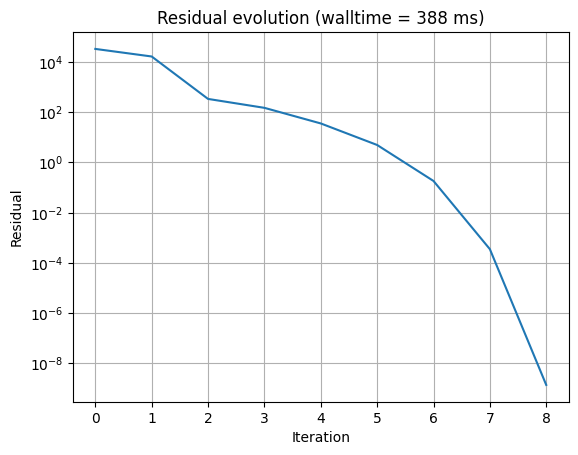

In [40]:
import matplotlib.pyplot as plt
plt.semilogy(dicoSol["residual"])
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title(f"Residual evolution (walltime = {1000 * dicoSol["wall_time"]:.0f} ms)")
plt.grid()
plt.show()